bert ann

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoscaMitrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if validation == True:
		val_to_plot = [model.history["val_"+el] for el in labels]
	to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [3]:
preprocess_link = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoder_link = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4"

preprocessor = hub.KerasLayer(preprocess_link)
encoder = hub.KerasLayer(encoder_link)

def get_embedings_sentences(sentences):
	preprocessed_text = preprocessor(sentences)
	return encoder(preprocessed_text)["pooled_output"]
	#return encoder(preprocessed_text)["sequence_output"]
 
get_embedings_sentences(["Hello fellow humans!"]) 

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.7502277 , -0.13671456,  0.34805366,  0.45483565, -0.32820255,
         0.00750104,  0.82495487,  0.08206423,  0.22131631, -0.9988444 ,
         0.26265964,  0.08342557,  0.9605094 , -0.07627685,  0.8965189 ,
        -0.4565765 , -0.08621861, -0.4226598 ,  0.24628411, -0.5744989 ,
         0.44919172,  0.8881553 ,  0.55336344,  0.15241079,  0.20557725,
         0.17250198, -0.52908266,  0.89130056,  0.9129521 ,  0.5484023 ,
        -0.5697616 ,  0.04072607, -0.96261215, -0.10015959,  0.3376387 ,
        -0.9447048 ,  0.00531326, -0.6605004 ,  0.08838216,  0.10863174,
        -0.8132668 ,  0.10283432,  0.9858325 , -0.37569004, -0.1333966 ,
        -0.28062207, -0.9987455 ,  0.13708162, -0.76875407, -0.4452786 ,
        -0.1691201 , -0.5963505 ,  0.01558585,  0.23921967,  0.27617282,
         0.46880317, -0.22998405, -0.00318363, -0.00855811, -0.3808298 ,
        -0.5191878 ,  0.15526955,  0.00151621, -0.8110866 , -0.09670857,
 

In [4]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

In [5]:
def label_distorsion_binary(row):
    if row["Dominant Distortion"] == "No Distortion":
        return 0
    return 1

therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
data = pd.merge(therapis_responses,annotated_data,on='Id_Number').drop(["Question"], axis=1)
data["Distortion"] = data.apply(label_distorsion_binary, axis=1)
data_list = data.values.tolist()
# 0 = ANSWER   ,   1 = ID   ,   2 = QUESTION   ,   3 = DISTORTED PART   ,
# 4 = DOMINANT DISTORTION   ,   5 = SECONDARY DISTORTION   ,   6 = DISTORTION 1/0

# ----------------------------------------------------------------------

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data["Patient Question"], data["Distortion"])

In [7]:
X_train_sw, X_test_sw, Y_train_sw, Y_test_sw = train_test_split(list(map(remove_stop_words,data["Patient Question"])), data["Distortion"])

In [8]:
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# ------------------------------------------------

In [9]:


#BERT
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)
#NN
#layer = tf.keras.layers.Dense(10,activation="relu")(outputs["pooled_output"])
#layer = tf.keras.layers.Dropout(0.25,name="dropout")(layer)
#layer = tf.keras.layers.Dense(1,activation="sigmoid",name="output")(layer)
layer = tf.keras.layers.Dropout(0.05,name="dropout")(outputs["pooled_output"])
layer = tf.keras.layers.Dense(1,activation="sigmoid",name="output")(layer)

#Model
model = tf.keras.Model(inputs=[text_input],outputs=[layer])

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [10]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=2)

Epoch 1/2
60/60 [==============================] - 35s 408ms/step - loss: 0.6605 - accuracy: 0.6183 - precision: 0.6331 - recall: 0.9311 - val_loss: 0.6272 - val_accuracy: 0.6635 - val_precision: 0.6702 - val_recall: 0.9386
Epoch 2/2
60/60 [==============================] - 23s 378ms/step - loss: 0.6399 - accuracy: 0.6363 - precision: 0.6508 - recall: 0.9067 - val_loss: 0.6185 - val_accuracy: 0.6619 - val_precision: 0.6616 - val_recall: 0.9705


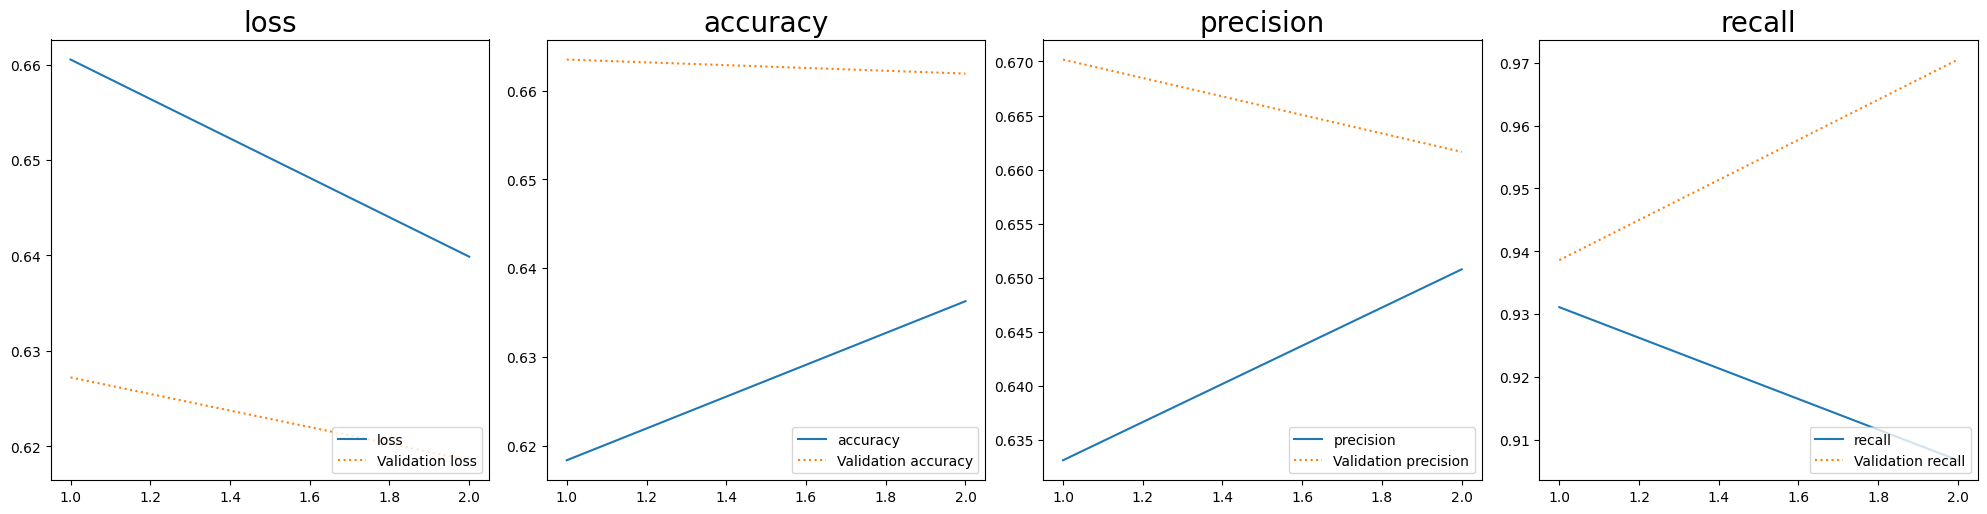

In [11]:
plot_train_val_data(history,["loss","accuracy","precision","recall"],True)


# ------------------------------------------------

In [12]:
sentences = data["Patient Question"].tolist()
sentences = list(map(remove_stop_words,sentences))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

VOCAB_LEN = len(tokenizer.word_index) + 1
#MAX_LEN = find_max_list(sequences)
MAX_LEN = 2000

padded_sequences = pad_sequences(sequences,maxlen=MAX_LEN, padding='post')

#tokenizer.sequences_to_texts(padded_sequences)[:3]

X_train_sw_tokenizer, X_test_sw_tokenizer, Y_train_sw_tokenizer, Y_test_sw_tokenizer = train_test_split(padded_sequences, np.array(data["Distortion"]))

# ANN
model = Sequential() 
n_dim = 2
model.add(Embedding(VOCAB_LEN, n_dim, input_length=MAX_LEN))#Vocabulary size of Tokenizer / Number of dimensions in embedding space / Length of padded sequence
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
model.summary()
hist = model.fit(X_train_sw_tokenizer,Y_train_sw_tokenizer,validation_data=(X_test_sw_tokenizer,Y_test_sw_tokenizer),epochs=2)


# CNN
n_dim = 2
seq_len = 3
model2 = Sequential()
model2.add(Embedding(VOCAB_LEN, n_dim, input_length=MAX_LEN))
model2.add(Conv1D(n_dim, seq_len, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(n_dim, seq_len, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
model2.summary()
hist2 = model2.fit(X_train_sw_tokenizer,Y_train_sw_tokenizer,validation_data=(X_test_sw_tokenizer,Y_test_sw_tokenizer),epochs=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 2)           23258     
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dropout (Dropout)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 32)                128032    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 151,323
Trainable params: 151,323
Non-trai

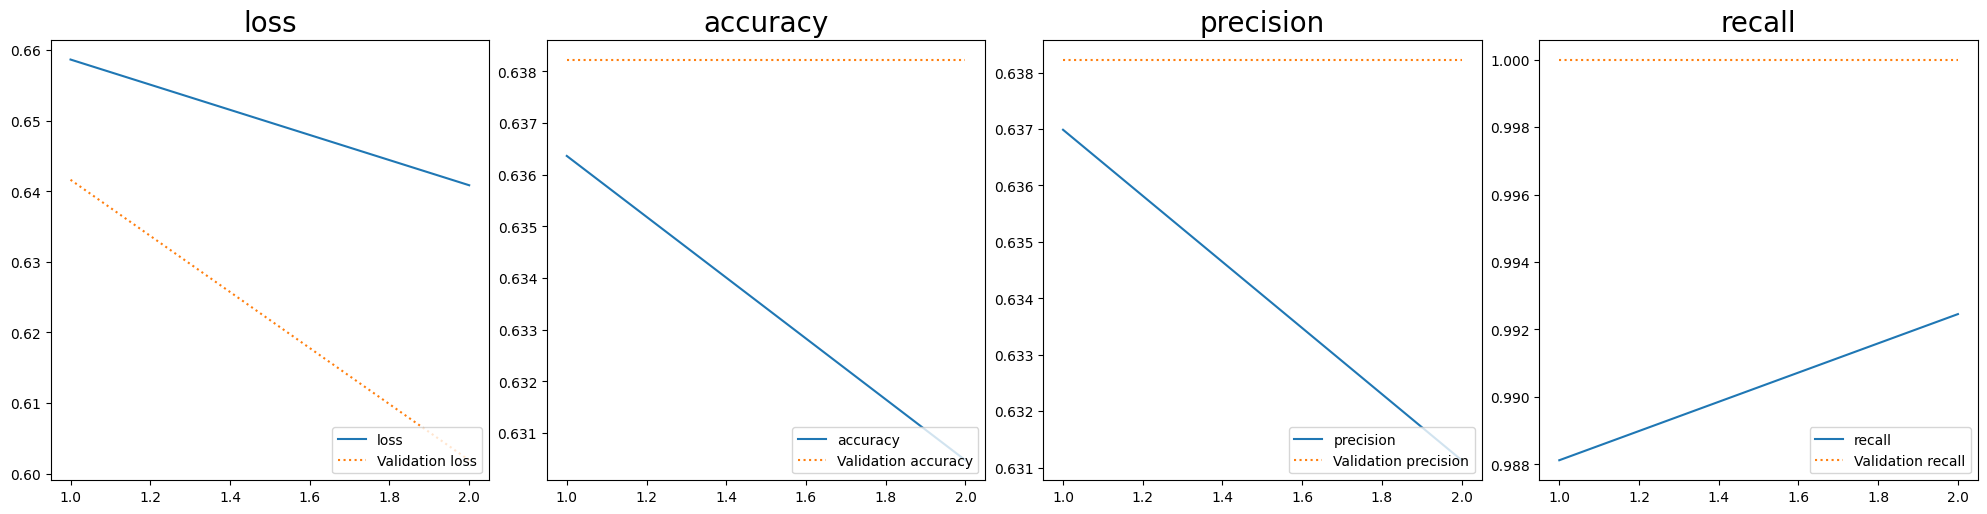

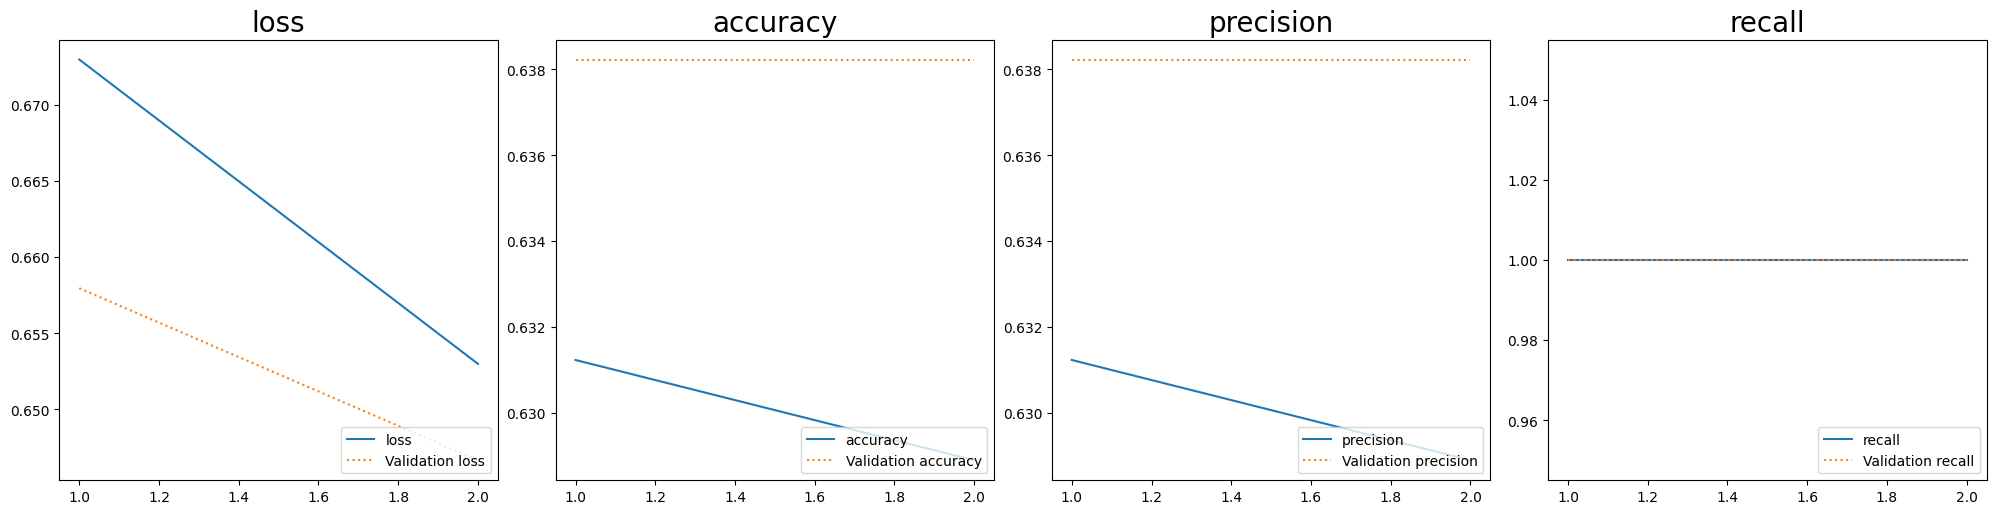

In [13]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)
plot_train_val_data(hist2,["loss","accuracy","precision","recall"],True)


# ------------------------------------------------

c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text(50.722222222222214, 0.5, 'Truth')

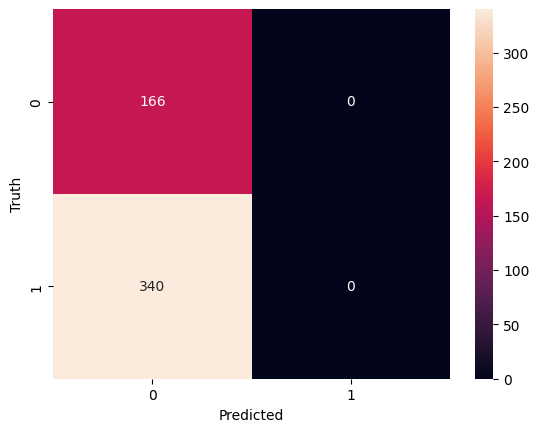

In [14]:
questions = data["Patient Question"].tolist()
distortions = data["Distortion"].tolist()

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
#sbert_model = SentenceTransformer('all-mpnet-base-v2')

questions_embeded = sbert_model.encode(questions)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(questions_embeded, distortions, test_size=0.2)

classifier = KNeighborsClassifier(n_neighbors=7, p=13, metric='euclidean')
classifier.fit(X_train_bert,y_train_bert)

classifier.score(X_test_bert,y_test_bert)

y_predicted = classifier.predict(X_test_bert)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(y_test_bert, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text(50.722222222222214, 0.5, 'Truth')

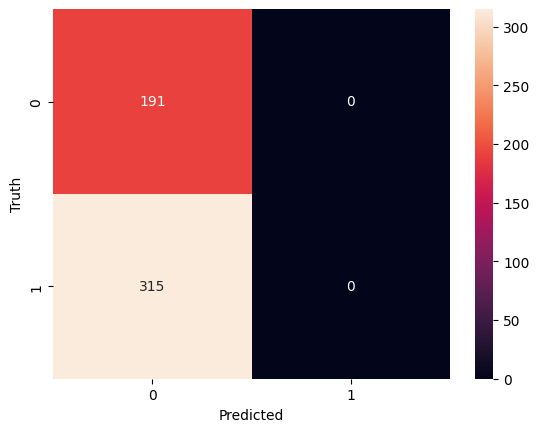

In [15]:
questions_stopword = list(map(remove_stop_words,questions))

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
#sbert_model = SentenceTransformer('all-mpnet-base-v2')

questions_stopword_embeded = sbert_model.encode(questions)

X_train_sw_bert, X_test_sw_bert, y_train_sw_bert, y_test_sw_bert = train_test_split(questions_stopword_embeded, distortions, test_size=0.2)

classifier2 = KNeighborsClassifier(n_neighbors=7, p=13, metric='euclidean')
classifier2.fit(X_train_sw_bert,y_train_sw_bert)

classifier2.score(X_test_sw_bert,y_test_sw_bert)

y_predicted = classifier2.predict(X_test_sw_bert)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(y_test_sw_bert, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [16]:
model = Sequential() 
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)

input_shape = X_train_bert.shape
model.build(input_shape)

model.summary()

hist = model.fit(X_train_bert,np.array(y_train_bert),validation_data=(X_test_bert,np.array(y_test_bert)),epochs=10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (2024, 16)                12304     
                                                                 
 dropout_2 (Dropout)         (2024, 16)                0         
                                                                 
 dense_4 (Dense)             (2024, 16)                272       
                                                                 
 dropout_3 (Dropout)         (2024, 16)                0         
                                                                 
 dense_5 (Dense)             (2024, 1)                 17        
                                                                 
Total params: 12,593
Trainable params: 12,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
64/64 [==============================] 

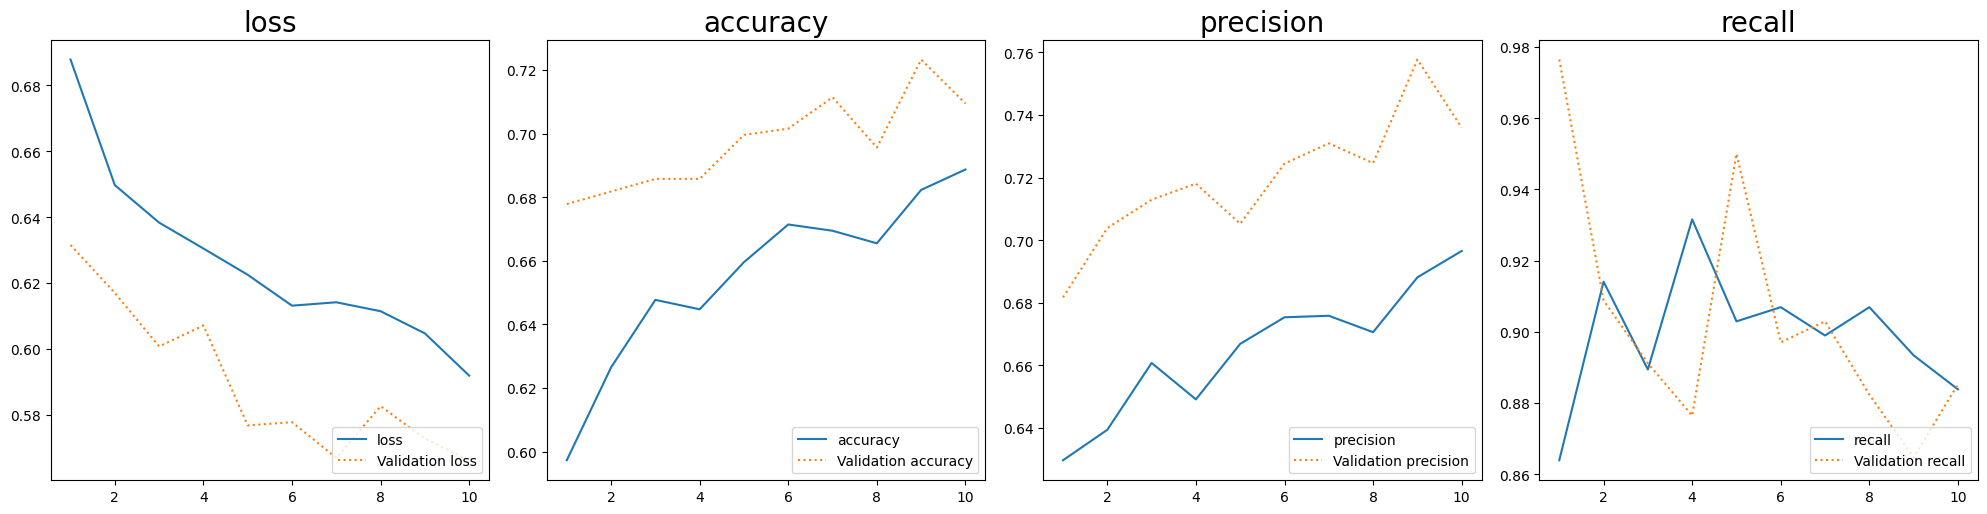

In [17]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)

16/16 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'Truth')

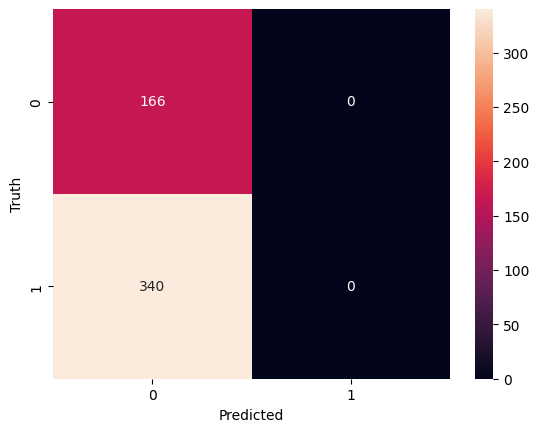

In [18]:
y_predicted = model.predict(X_test_bert)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(y_test_bert, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')